# Spectral Unmixing

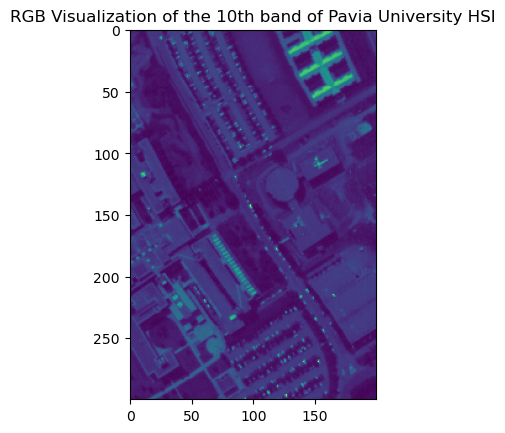

In [1]:
import scipy.io as sio
import pandas as pd
import numpy as np
import scipy.optimize
import matplotlib.pyplot as plt
import sklearn
from sklearn.linear_model import LinearRegression,Lasso
from sklearn.exceptions import ConvergenceWarning
from sklearn.metrics import mean_squared_error as mse
import warnings
from tqdm import tqdm

Pavia = sio.loadmat('data/PaviaU_cube.mat')
HSI = Pavia['X'] #Pavia HSI : 300x200x103

ends = sio.loadmat('data/PaviaU_endmembers.mat') # Endmember's matrix: 103x9
endmembers = ends['endmembers']

#Perform unmixing for the pixels corresponding to nonzero labels
ground_truth= sio.loadmat('data/PaviaU_ground_truth.mat')
labels=ground_truth['y']

fig = plt.figure()
plt.imshow(HSI[:,:,10])
plt.title('RGB Visualization of the 10th band of Pavia University HSI')
plt.show()

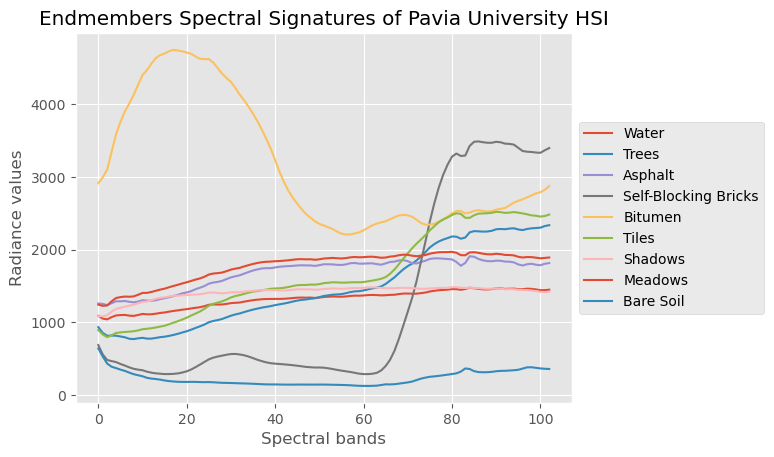

In [2]:
# line plot ========================================================
plt.style.use('ggplot')  # Set ggplot style
# Define the specified labels
materials = [
    'Water',
    'Trees',
    'Asphalt',
    'Self-Blocking Bricks',
    'Bitumen',
    'Tiles',
    'Shadows',
    'Meadows',
    'Bare Soil'
]

fig, ax = plt.subplots()


# Use broadcasting to plot all columns at once with specified labels
ax.plot(endmembers, label=materials)

ax.set_ylabel('Radiance values')
ax.set_xlabel('Spectral bands')
ax.set_title('Endmembers Spectral Signatures of Pavia University HSI')
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))  # Place legend to the right

plt.show()
plt.style.use('default')

In [3]:
abundanceMaps = []
Y_pred = []

X = endmembers
y = HSI.reshape((300*200,103))
# To θ0 den exei fisiki simasia ara den to ipologizw

# ===== (a) Least squares ==================================================
y_pred = np.zeros((300,200))

thetaHAT = np.linalg.inv(X.T@X)@(X.T@y.T) # Calculate the new theta Coefficients
thetaHAT = thetaHAT.T
thetaHAT = thetaHAT.reshape(300,200,9)

abundanceMaps.append(thetaHAT)

In [4]:
# ===== (b) Least squares imposing the sum-to-one constraint ==================================================
import cvxpy as cp
abMap = np.zeros((300,200,9))
y_pred = np.zeros((300,200))

for i in tqdm(range(300)):
    for j in range(200):
        y = HSI[i,j,:]
        coefficients = cp.Variable(X.shape[1])                           # Define the coefficients as variables
        objective    = cp.Minimize(cp.sum_squares(X @ coefficients - y)) # Define the objective function (sum of squared residuals)
        constraint   = [cp.sum(coefficients) == 1]                       # Define the constraint (sum-to-one)
        problem      = cp.Problem(objective, constraint)                 # Formulate and solve the problem
        problem.solve()
        coefficients = np.array(coefficients.value)                      # Extract the coefficients
        abMap[i,j,:] = coefficients                                      # append coefficients of pixel (i,j) in the abundance map of this approach

abundanceMaps.append(abMap)
#print('Coeffs of sum-to-one approach: \n',abMap[30,150,:])

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [08:46<00:00,  1.76s/it]


In [5]:
# ===== (c) Least squares imposing the non-negativity constraint on the entries of θ ============================
y = HSI.reshape((300*200,103)) # Redifine y as the entirematrix, reshaped as (60000,103)

model = LinearRegression(fit_intercept=False,positive=True).fit(X, y.T) # Constrain the coefficients to be positive. Fit the LS model.
abMap = model.coef_                                                     # Extract the coefficients
abMap = abMap.reshape(300,200,9)                                        # Reshape the coefficients matrix to its proper form.

abundanceMaps.append(abMap)

In [6]:
# ===== (d) Least squares imposing both the non-negativity and the sum-to-one constraint on the entries of θ.====================
# pip install cvxopt
from cvxopt import matrix, solvers
# Suppress print output
solvers.options['show_progress'] = False

abMap = np.zeros((300,200,9)) # Empty matrix to store abundance Maps

for i in tqdm(range(300)):
    for j in range(200):
        y = HSI[i,j,:]

        m, n = X.shape # Define the size of the problem
        # Objective Function Matrices
        P = matrix(np.dot(X.T, X))
        q = matrix(np.dot(-X.T,y.T))
        # Inequality Constraint Matrices
        G = matrix(-np.eye(n))
        h = matrix(np.zeros(n))
        # Equality Constraint Matrices
        A = matrix(np.ones(n)).T
        b = matrix(1.0)

        # Solve the quadratic programming problem
        sol = solvers.qp(P, q, G, h, A, b);

        # Extract the coefficients
        abMap[i,j,:] = np.array(sol['x']).flatten()

abundanceMaps.append(abMap)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [06:22<00:00,  1.28s/it]


In [7]:
# ===== (e) LASSO, i.e., impose sparsity on θ via 𝑙1 norm minimization. ====================
y = HSI.reshape((300*200,103)) # Redifine y as the entirematrix, reshaped as (60000,103)

# Suppress ConvergenceWarning
warnings.filterwarnings("ignore", category=ConvergenceWarning)

model = Lasso(fit_intercept=False).fit(X, y.T)
abMap = model.coef_
abMap = abMap.reshape(300,200,9)

abundanceMaps.append(abMap)

In [8]:
# ===== (e) LASSO with Positive constraint ====================
model = Lasso(fit_intercept=False,positive=True).fit(X, y.T)
abMap = model.coef_
abMap = abMap.reshape(300,200,9)

abundanceMaps.append(abMap)

In [9]:
compare = pd.DataFrame()
compare['LS']        = abundanceMaps[0][30,150,:]
compare['LS_SUM']    = abundanceMaps[1][30,150,:]
compare['LS_POS']    = abundanceMaps[2][30,150,:]
compare['CONVEX']    = abundanceMaps[3][30,150,:]
compare['Lasso']     = abundanceMaps[4][30,150,:]
compare['Lasso_POS'] = abundanceMaps[5][30,150,:]
compare

,LS,LS_SUM,LS_POS,CONVEX,Lasso,Lasso_POS
0,4.448327,1.179717,0.000000,-2.450197e-09,3.422486,0.000000
1,-0.748112,-0.474004,0.000000,-2.326545e-09,0.352117,0.000000
2,1.691132,0.656307,0.000000,-2.303259e-09,-0.352170,0.000000
3,0.038060,-0.003348,0.000000,-2.444532e-09,0.428004,0.000000
4,1.333099,1.321410,1.341442,1.000000e+00,1.261224,1.341442
5,0.523174,0.394147,0.000000,5.481293e-10,-1.713811,0.000000
6,-0.731843,0.065546,0.000000,-2.437883e-09,-1.044337,0.000000
7,-3.940573,-1.394600,0.000000,-2.332576e-09,0.067452,0.000000
8,-2.115973,-0.745175,0.000000,-2.491666e-09,-2.308059,0.000000


In [10]:
# Calculate Reconstrucion Error
yPred    = []           # Store all predicted HSI tables
recError = []           # Store reconstrucion error for each approach
recError1 = []           # Store reconstrucion error for each approach
mask     = (labels > 0) # Create this mask to apply to the y_preds, inorder to isolate the pure pixels
HSImasked = HSI.copy()
HSImasked[mask != 1] = 0
for i in range(5):
    B = abundanceMaps[i] # Extract the abundance Map for this approach
    Y = (B.reshape(300*200,9) @ X.T).reshape(300,200,103) # θ*Χ.Τ (60Κ,9)@(9,103) ---> Y(300,200,103)
    Y[mask != 1] = 0
    yPred.append(Y)
    #recError.append(mse( HSImasked.reshape(300*200,103), Y.reshape(300*200,103) ))
    recError1.append( np.mean( np.linalg.norm( (HSImasked - Y).reshape(300*200,103), 2, axis=1) ) )


# Sample lists
#data = {'0': recError, '1': recError1}
data = {'Reconstruction Error': recError1}
index_list = ['LS','LS_SUM','LS_POS','CONVEX','Lasso']
df = pd.DataFrame(data)
df = df.set_index(pd.Index(index_list))
df

#del sol, q, P, objective, n, m, i, j, h, G, constraint, coefficients, b, abMap, A

,Reconstruction Error
LS,71.755197
LS_SUM,82.447398
LS_POS,139.258395
CONVEX,263.278770
Lasso,92.949445


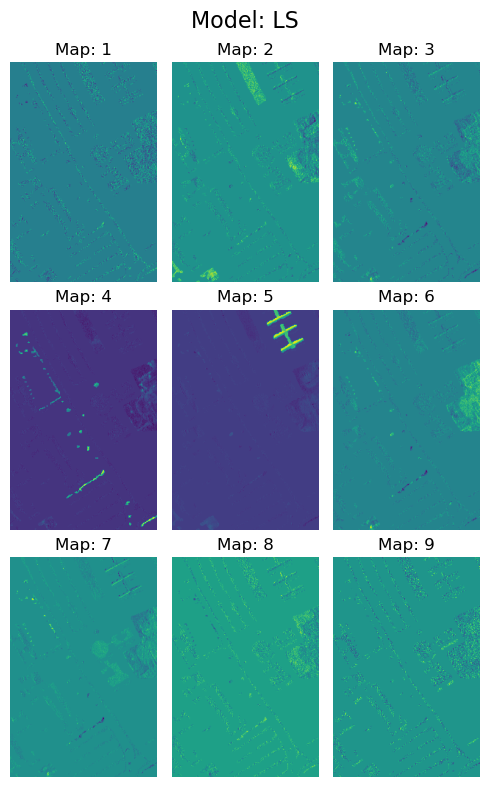

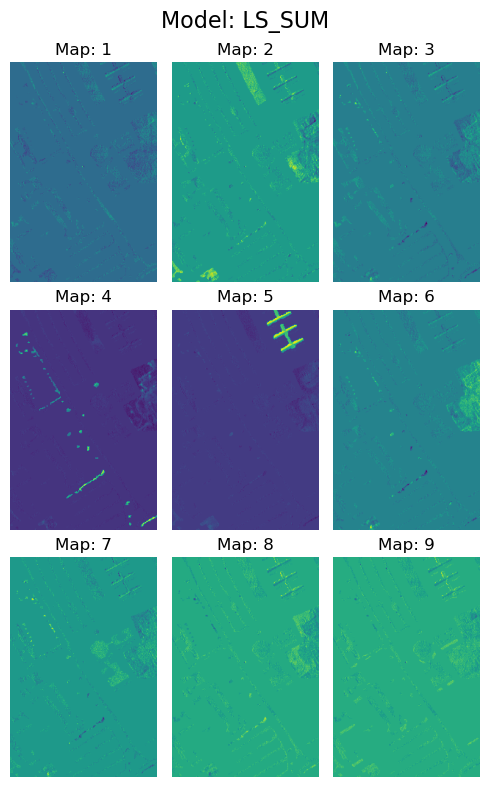

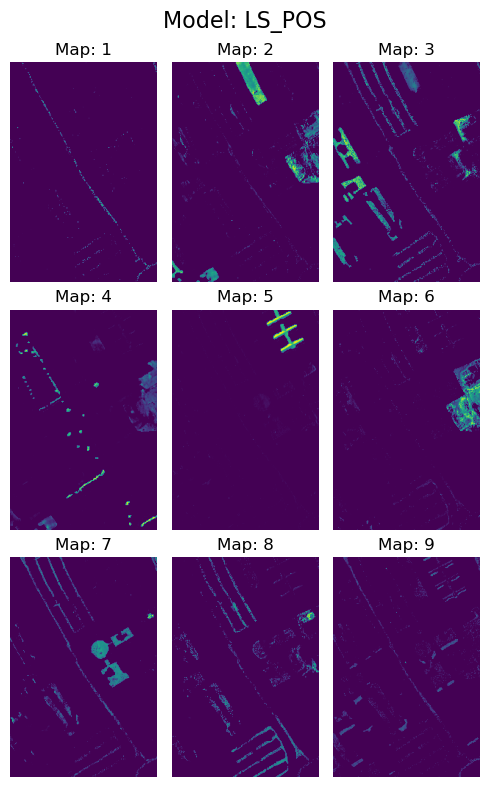

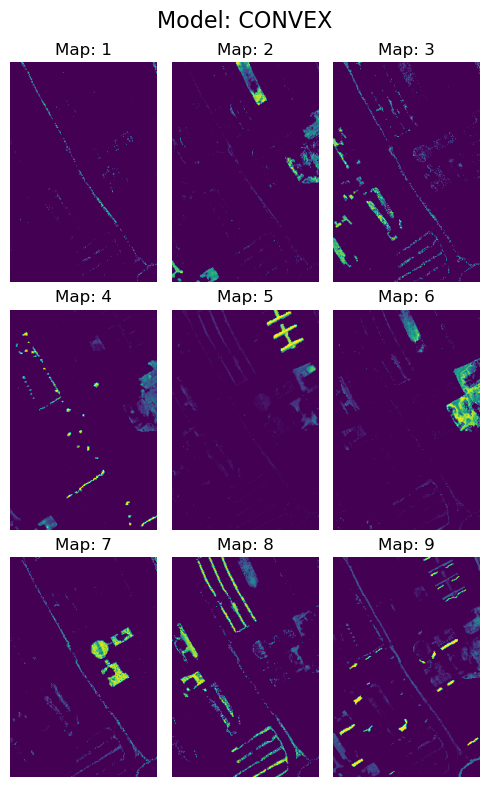

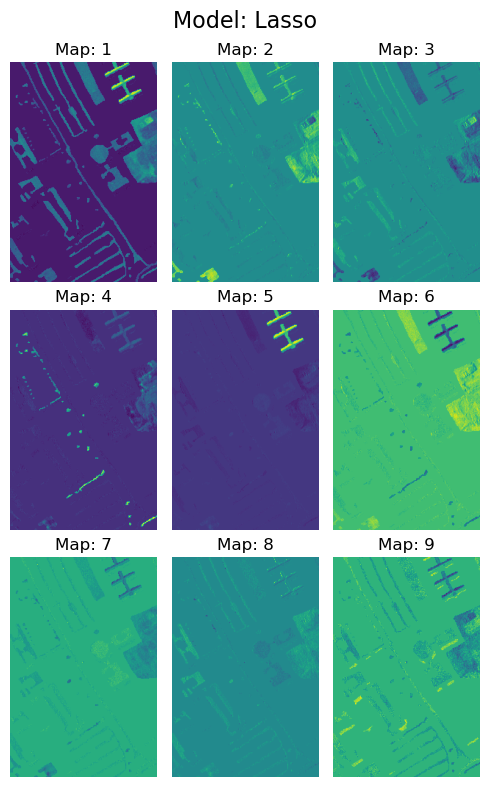

In [11]:
# %% Plot abMaps
        
for imodel in range(5):
    fig, axs = plt.subplots(3, 3, figsize=(5,8), tight_layout=True)
    fig.suptitle(f'Model: {index_list[imodel]}', fontsize=16)

    for jMap in range(9):
        abMap = abundanceMaps[imodel]
        mapSlice = abMap[:, :, jMap]
        mapSlice[mask != 1] = 0

        # Calculate subplot indices
        row_idx = jMap // 3
        col_idx = jMap % 3

        # Plot on the corresponding subplot
        axs[row_idx, col_idx].imshow(mapSlice, cmap='viridis')
        axs[row_idx, col_idx].axis('off')
        axs[row_idx, col_idx].set_title(f'Map: {jMap + 1}')

    # Save the figure
    # fig.savefig(f'abMap.{imodel+1}.{jMap+1}.png')
    plt.show()

# Classification

In [26]:
import scipy.io as sio
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
from sklearn.naive_bayes import GaussianNB
from scipy.stats import multivariate_normal

In [27]:
class myMinimumEuclideanDistanceClassifier(BaseEstimator, ClassifierMixin):
    def __init__(self):
        self.mus = None

    def fit(self, X_train, y_train):
        trainDF1 = pd.DataFrame(X_train)
        trainDF1['label'] = y_train
        groups = [group_df.values[:, :-1] for _, group_df in trainDF1.groupby('label')]
        self.mus = [group.mean(axis=0) for group in groups]

    def predict(self, X_test):
        residuals = self.mus - X_test[:, np.newaxis, :]
        dist_from_centers = np.sum(residuals * residuals, axis=-1)
        y_pred = np.argmin(dist_from_centers, axis=1) + 1
        return y_pred

    def score(self, X_test, y_test):
        y_pred = self.predict(X_test)
        return accuracy_score(y_test, y_pred)

class myBayesianClassifier(BaseEstimator, ClassifierMixin):
    def __init__(self, means, covariances, a_prioris):
        self.mvn_list = []
        self.means = means
        self.covariances = covariances
        self.a_prioris = a_prioris

    def fit(self, X, y=None):
        self.mvn_list = [multivariate_normal(mean=mean, cov=covariance) for mean, covariance in zip(self.means, self.covariances)]
        return self

    def predict(self, X):
        n_classes = len(self.mvn_list)
        MAP = np.array([self.a_prioris[i] * self.mvn_list[i].pdf(X) for i in range(n_classes)]).T
        y_pred = np.argmax(MAP, axis=1) + 1
        return y_pred

    def score(self, X_test, y_test):
        y_pred = self.predict(X_test)
        return accuracy_score(y_test, y_pred)


def plot_confusion_matrix(confusionMatrix, accuracy, model_name=None):
    # Define the labels
    labels = ['Water', 'Trees', 'Asphalt', 'Self-Blocking Bricks', 'Bitumen', 'Tiles', 'Shadows', 'Meadows', 'Bare Soil']

    # Convert numpy array to DataFrame
    confusion_df = pd.DataFrame(confusionMatrix, columns=labels)
    confusion_df = confusion_df.set_index(pd.Index(labels))

    # Create a heatmap of the confusion matrix
    plt.figure(figsize=(10, 8))  # Adjust the figure size if needed
    heatmap = sns.heatmap(confusion_df, annot=False, fmt='d', linewidths=1, cbar=False, cmap='Blues')

    # Manually add annotations to each cell
    for i in range(len(confusion_df)):
        for j in range(len(confusion_df.columns)):
            value = confusion_df.iloc[i, j]
            text = heatmap.text(j + 0.5, i + 0.5, f'{value}', ha='center', va='center', fontsize=10, color='black')

    # Add labels and dynamic title
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title(f'{model_name} - Confusion Matrix - Accuracy: {accuracy*100:.2f}')  # Use the model_name parameter

    # Set yticks on top of the plot
    plt.tick_params(axis='y', labeltop=True, labelbottom=False)

    # Show the plot
    plt.show()


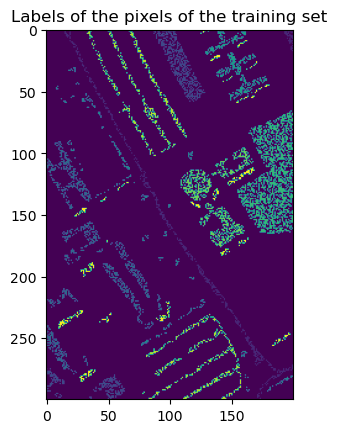

In [28]:
# Trainining set for classification
Pavia_labels = sio.loadmat('data/classification_labels_Pavia.mat')
Training_Set = (np.reshape(Pavia_labels['training_set'],(200,300))).T
Test_Set = (np.reshape(Pavia_labels['test_set'],(200,300))).T
Operational_Set = (np.reshape(Pavia_labels['operational_set'],(200,300))).T

fig = plt.figure()
plt.imshow(Training_Set)
plt.title('Labels of the pixels of the training set')
plt.show()

In [29]:
# ============== Extract Data Sets =============================
# Read the data:
Pavia = sio.loadmat('data/PaviaU_cube.mat')
HSI   = Pavia['X'] #Pavia HSI : 300x200x103
HSI   = HSI.reshape(300*200,103)        # reshape HSI into a table of pixel-bands

# Mask and split the data:
    
# Training_Set
trainDF          = pd.DataFrame(HSI)                # insert them into a trainDF
trainDF['label'] = Training_Set.reshape(300*200,1)  # add the Labels of each training pixel
trainDF          = trainDF[ trainDF['label'] != 0 ] # keep only the relevant training pixels
trainDF          = trainDF.reset_index(drop=True)   # Reset the index of the pixel after the filltering and drop the old index

# Test_Set
testDF          = pd.DataFrame(HSI)              # insert them into a testDF
testDF['label'] = Test_Set.reshape(300*200,1)    # add the Labels of each test pixel
testDF          = testDF[ testDF['label'] != 0 ] # keep only the relevant test pixels
testDF          = testDF.reset_index(drop=True)  # Reset the index of the pixel after the filltering

# Operational_Set
operationalDF          = pd.DataFrame(HSI)                            # insert them into a df
operationalDF['label'] = Operational_Set.reshape(300*200,1)           # add the Labels of each operational pixel
operationalDF          = operationalDF[ operationalDF['label'] != 0 ] # keep only the relevant operational pixels
operationalDF          = operationalDF.reset_index(drop=True)         # Reset the index of the pixel after the filltering

In [30]:
# ==== Pre Processing =============================================

X_train = trainDF.drop('label', axis=1).values
y_train = trainDF.label.values
X_test = testDF.drop('label', axis=1).values
y_test = testDF.label.values
X_op = operationalDF.drop('label', axis=1).values
y_op = operationalDF.label.values

nClasses = y_test.max()

# Split the X_train into list of different np tables per class
groups = [group_df.values[:,:-1] for _, group_df in trainDF.groupby('label')] 
# Store the centers of each class
mus = [group.mean(axis = 0) for group in groups] # group = [X1,X2,...,X103]
covs = [np.cov(group, rowvar=False) for group in groups] # for Bayes
aPrioris = [len(group)/len(trainDF) for group in groups]    

In [32]:
# ========= A ================
# Create a DataFrame to store performance statistics
index_values = ['Naive Bayes', 'MED', 'KNN', 'Bayesian']
columns = ['mean', 'std']
cvStats = pd.DataFrame(0.0, index=index_values, columns=columns) # Initialize the DataFrame with zeros

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 49/49 [00:32<00:00,  1.52it/s]


Text(0, 0.5, 'Success Rate')

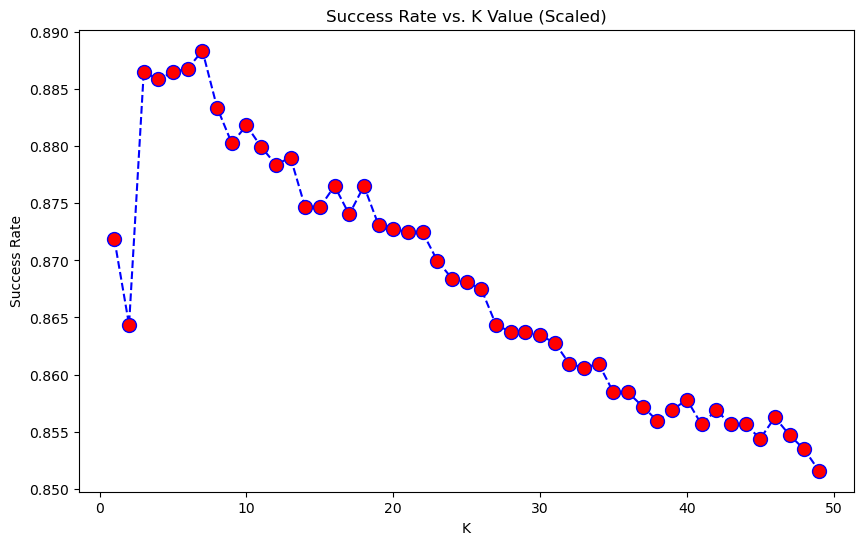

In [33]:
#========== KNN ==========
# Find the best K for Knn
error_rate = []
for i in tqdm(range(1,50)):
    knn = KNeighborsClassifier(n_neighbors=i).fit(X_train,y_train)
    error_rate.append(knn.score(X_test,y_test))

# Plot the Elbow
plt.figure(figsize=(10,6))
plt.plot(range(1,50),error_rate,color='blue', linestyle='dashed', marker='o',
         markerfacecolor='red', markersize=10)
plt.title('Success Rate vs. K Value (Scaled)')
plt.xlabel('K')
plt.ylabel('Success Rate')

                 mean       std
Naive Bayes  0.000000  0.000000
MED          0.000000  0.000000
KNN          0.847976  0.054148
Bayesian     0.000000  0.000000


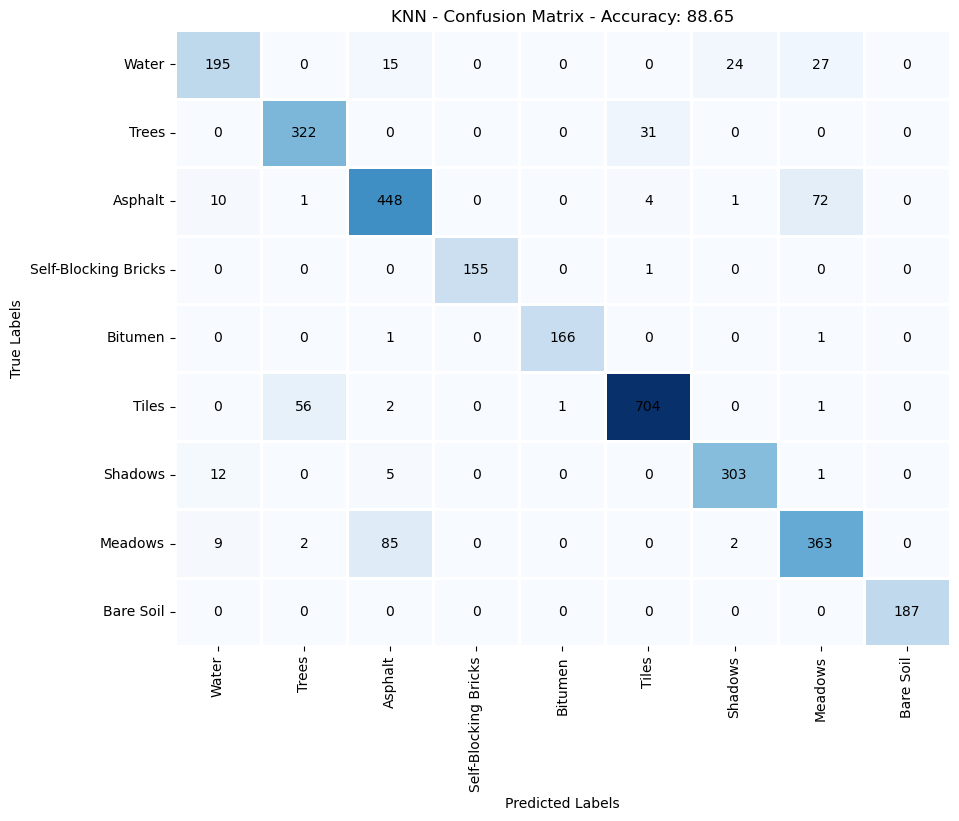

0.9198628001247272


In [34]:
# ================ KNN - A ============================================
knn = KNeighborsClassifier(n_neighbors=5)
scores = cross_val_score(knn, X_train, y_train, cv=10, n_jobs=-1)
cvStats.loc['KNN',:] = [scores.mean(),scores.std()]
print(cvStats)

# ================ KNN - B ============================================
# Best K ~= 5
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train,y_train)
score = knn.score(X_test,y_test) # Success Rate: $Accuracy=Number of Correct y_predictions/Total Number of Samples​$
y_pred = knn.predict(X_test)
# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plot_confusion_matrix(confusionMatrix=cm, accuracy=score, model_name='KNN')

# Operational
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_op,y_op)
score = knn.score(X_op,y_op)
print(score)

                 mean       std
Naive Bayes  0.644713  0.056765
MED          0.000000  0.000000
KNN          0.847976  0.054148
Bayesian     0.000000  0.000000


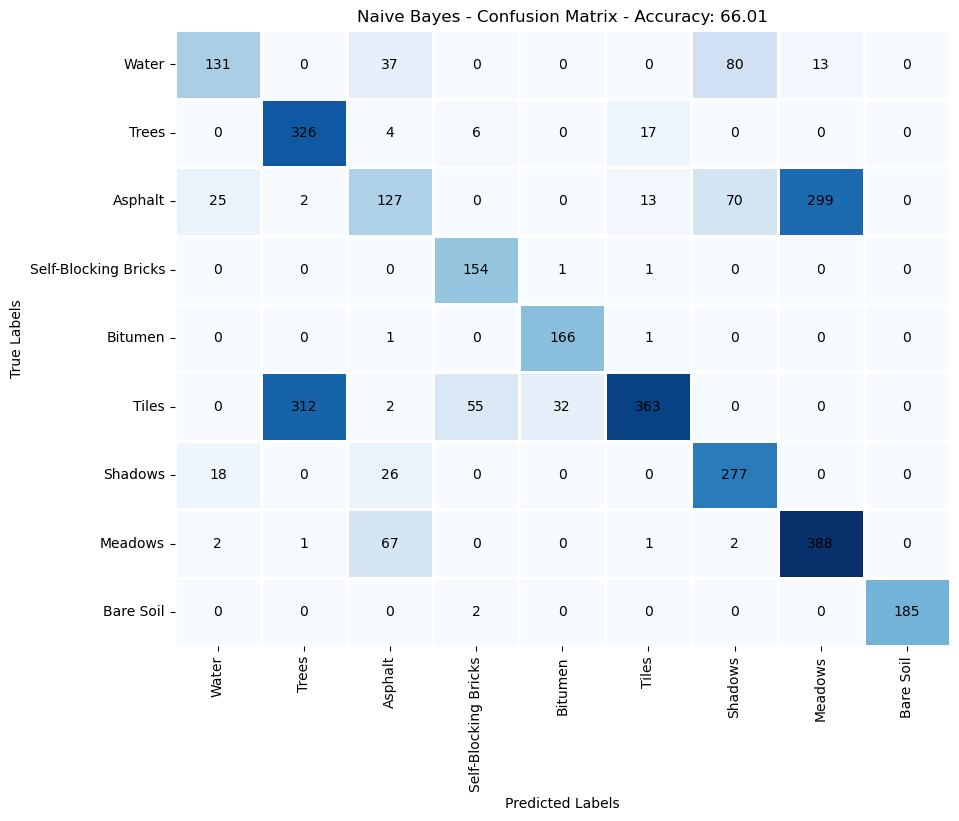

In [35]:
# ===================== Naive Bayes ==========================================
# A ===
nbc = GaussianNB().fit(X_train,y_train)
scores = cross_val_score(nbc, X_train, y_train, cv=10, n_jobs=-1)
cvStats.loc['Naive Bayes',:] = [scores.mean(),scores.std()]
print(cvStats)

# B ===
nbc = GaussianNB().fit(X_train,y_train)
score = nbc.score(X_test,y_test)
y_pred = nbc.predict(X_test)
# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plot_confusion_matrix(confusionMatrix=cm, accuracy=score, model_name='Naive Bayes')

                 mean       std
Naive Bayes  0.644713  0.056765
MED          0.551843  0.059575
KNN          0.847976  0.054148
Bayesian     0.000000  0.000000


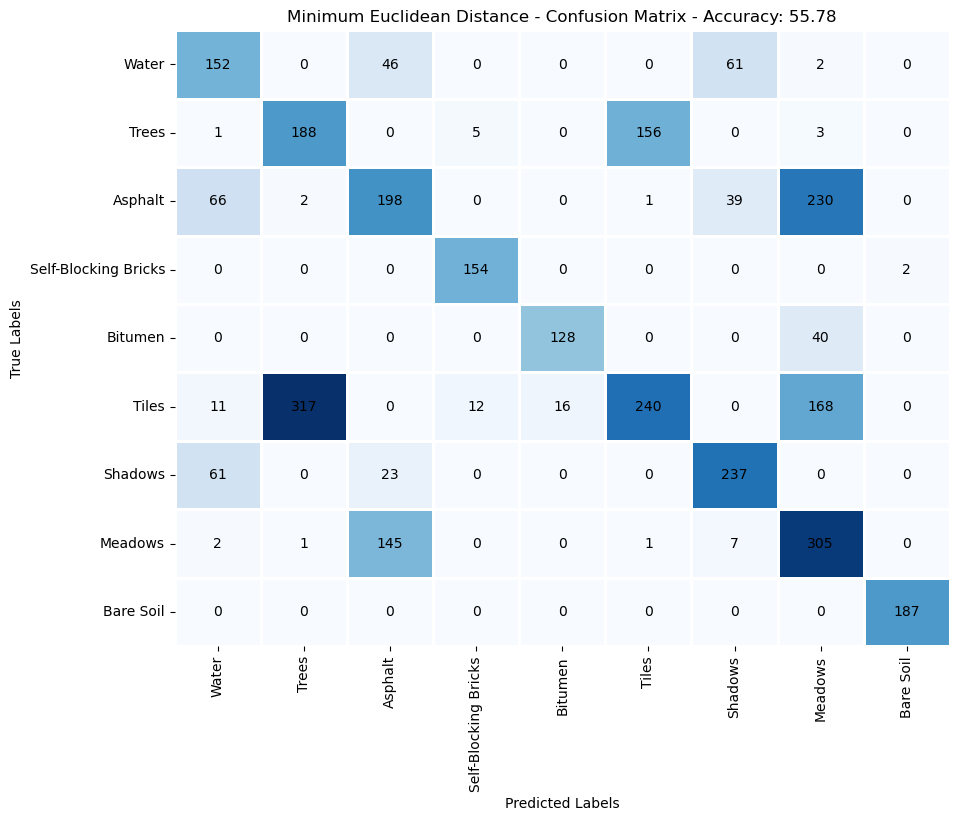

In [36]:
# ===================== Min Euclidean Distance ==========================================
# A ===
myTrainX = trainDF.iloc[:, :-1].values
myTrainY = trainDF['label'].values

medC = myMinimumEuclideanDistanceClassifier()

scores = cross_val_score(medC, myTrainX, myTrainY, cv=10, n_jobs=-1)
cvStats.loc['MED',:] = [scores.mean(),scores.std()]
print(cvStats)

# B ===
# MIN EUCLIDEAN
residuals       = mus - X_test[:, np.newaxis, :]         # For each test point, substract it from each center (mu) --> (nPoints,Centers,Features)
distFromCenters = np.sum(residuals * residuals, axis=-1) # Squeeze the squared features to get the the Euclidean Distance from each center
y_pred          = np.argmin(distFromCenters, axis=1) + 1 # the min E.D. is the best label
score           = accuracy_score(y_test, y_pred)

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plot_confusion_matrix(confusionMatrix=cm, accuracy=score, model_name='Minimum Euclidean Distance')

                 mean       std
Naive Bayes  0.644713  0.056765
MED          0.551843  0.059575
KNN          0.847976  0.054148
Bayesian     0.991268  0.005847


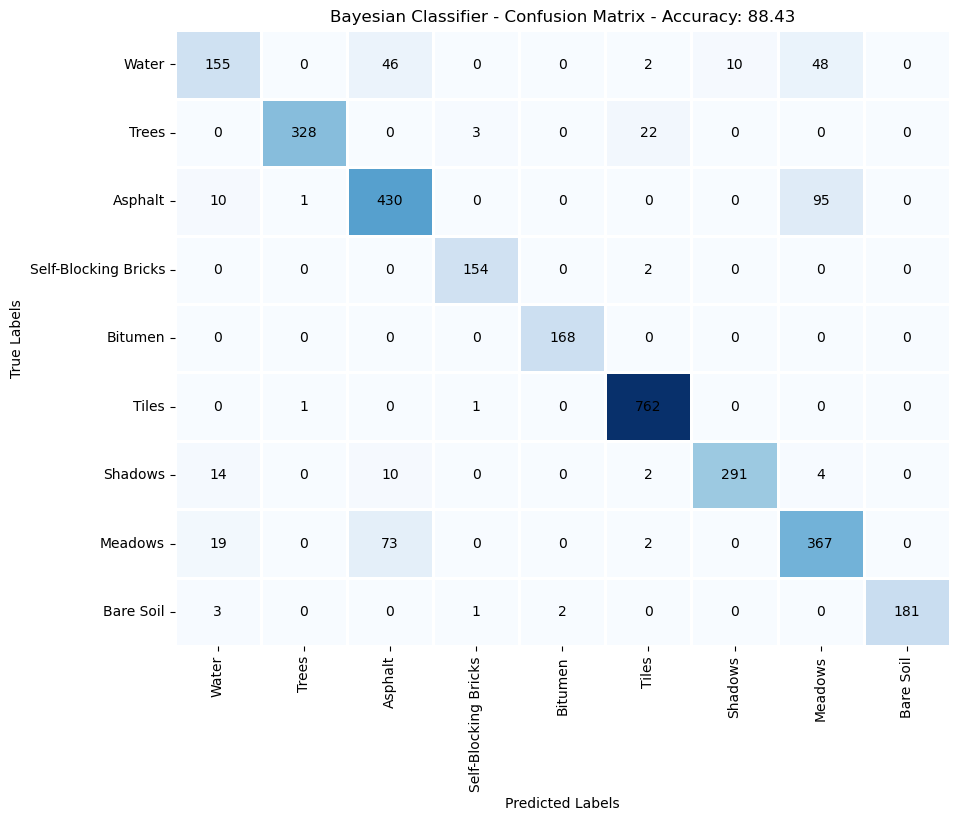

In [37]:
# ===================== Bayesian Classifier ==========================================
# A ===
mbC = myBayesianClassifier(mus, covs, aPrioris)

# Use cross_val_score to perform cross-validation
scores = cross_val_score(mbC, X_train, y_train, cv=10, n_jobs=-1)
cvStats.loc['Bayesian',:] = [scores.mean(),scores.std()]
print(cvStats)

# B ===

mvnL = [] # list to store all fitted normal dists
for mean, covariance in zip(mus, covs):
    distribution = multivariate_normal(mean=mean, cov=covariance)
    mvnL.append(distribution)

MAP = np.array( [ aPrioris[i] * mvnL[i].pdf(X_test) for i in range(nClasses)] ).T
y_pred = np.argmax(MAP,axis=1) + 1
score = accuracy_score(y_test, y_pred)

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plot_confusion_matrix(confusionMatrix=cm, accuracy=score, model_name='Bayesian Classifier')